In [1]:
import requests
import json
import pandas as pd
import requests
import json
import datetime
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import scipy.stats as st
import sklearn.linear_model as lm
import matplotlib.pyplot as plt


# Change these values for different dates
year = "2024"
month = "7"
day = "12"
hour = "12"
minute = "30"
second = "0"

site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{minute.zfill(2)}%3A{second.zfill(2)}'
print(site)
response_API = requests.get(site)
data = response_API.text
data = json.loads(data)
timestamp = data["items"][0]["timestamp"]
print(timestamp)

data = data["items"][0]["carpark_data"]
with open("EE4211data.json", 'w') as fp:
    json.dump(data, fp)
df = pd.read_json("EE4211data.json")
for heading in ("total_lots","lot_type","lots_available"):
    df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])
df = df.drop(["carpark_info"], axis=1)
df

C:\Users\power\AppData\Local\Temp\ipykernel_33696\2920418244.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2024-07-12T12%3A30%3A00
2024-07-12T12:28:27+08:00


,carpark_number,update_datetime,total_lots,lot_type,lots_available
0,HE12,2024-07-12T12:28:14,105,C,27
1,HLM,2024-07-12T12:27:54,583,C,28
2,RHM,2024-07-12T12:28:14,329,C,131
3,BM29,2024-07-12T12:28:19,97,C,0
4,Q81,2024-07-12T12:28:07,97,C,0
...,...,...,...,...,...
1972,BA7,2024-07-12T12:27:28,261,C,164
1973,SS1L,2024-07-12T12:27:03,4,C,1
1974,BA9,2024-07-12T12:26:50,918,C,650
1975,H3DL,2024-07-12T12:21:51,2,C,0


#### 2.1 Portion Can you explain why you may want to forecast the carpark availability in the future? Who wouldfind this information valuable? What can you do if you have a good forecasting model?


Forecasting carpark availability can help the government manage traffic and reduce congestion. Knowing when and where parking spots are likely to be free enables the government to direct traffic more effectively or invest in infrastructure where it’s most needed. Drivers benefit, too, by getting real-time updates on parking, saving them time. Businesses can also use this data to anticipate peak times and prepare accordingly.

Policy makers, urban planners, drivers, and businesses all find this information valuable. With an accurate forecasting model, we can optimize parking based on demand, support infrastructure planning, and provide real-time updates. For the model to be truly effective, it should be trained on a large, diverse dataset that includes variables like public holidays. For instance, the public holiday on August 9 in Singapore led to lower carpark availability, a trend the model might miss if trained solely on typical workdays.



Root Mean Square Error (RMSE): 0.050565867731797734
R-squared (R^2): 0.3443329088542003
Mean Absolute Error (MAE): 0.04119285244407617
Mean Absolute Percentage Error (MAPE): 8.091667553795405


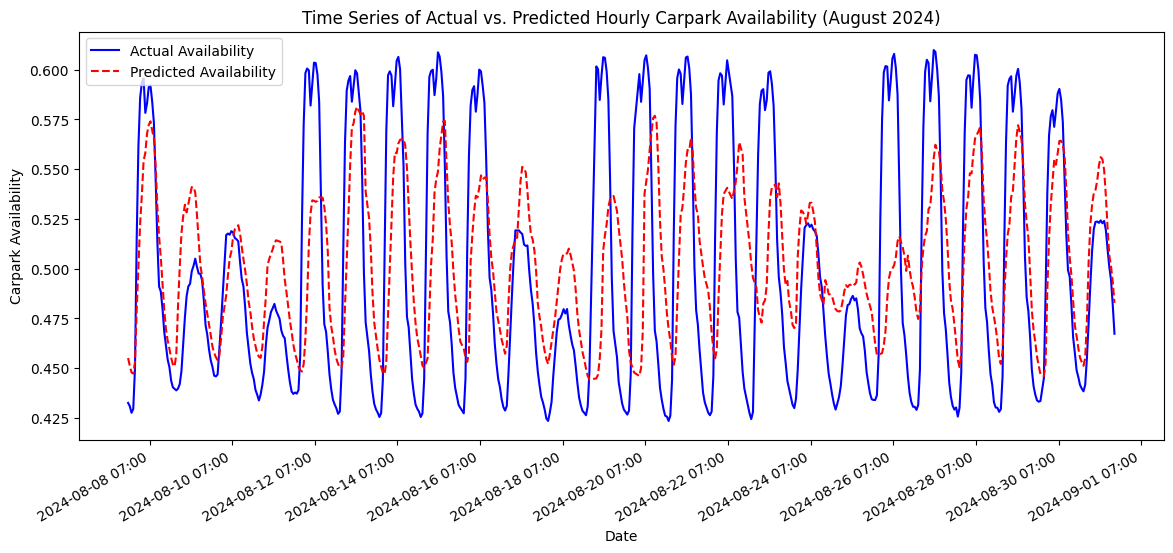

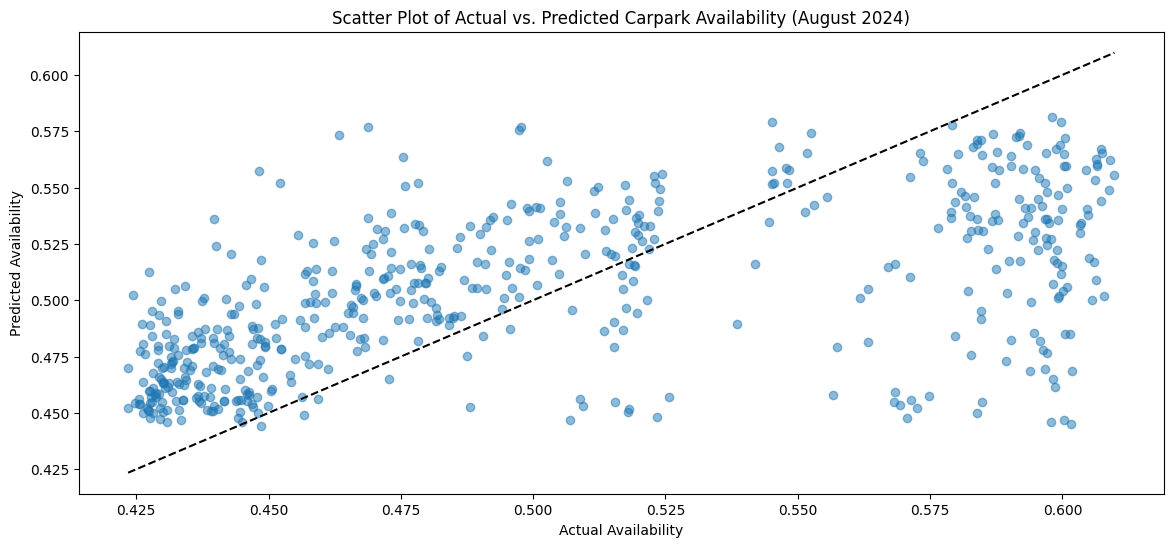

In [23]:


#lag1(day 1)
# #lag168 - 7 days (1 week)
#features totallot - 
#lag120 - 5 days 

#Assumptions of ridge regression code - and the solution of the code
# try different activations functions tanh, sigmoid, learning rate, try different stochastic gradients, trainingsize, iterations, training and testing splits 
# Feature Extractions

import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator

import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator

# Load the data files for July and August 2024
july_data = pd.read_csv(r"C:\Users\power\Downloads\carpark_availability_july_2024.csv")
august_data = pd.read_csv(r"C:\Users\power\Downloads\carpark_availability_aug_2024.csv")

# Step 1: Data Preparation
# Convert timestamps to datetime format and set as index to handle time series data
july_data['timestamp'] = pd.to_datetime(july_data['timestamp'])
august_data['timestamp'] = pd.to_datetime(august_data['timestamp'])
july_data.set_index('timestamp', inplace=True)
august_data.set_index('timestamp', inplace=True)

# Step 2: Feature Engineering - Creating Lag Features
# Adding lag 24 to the array of lags to capture daily fluctuations
lags = [168, 120, 24, 4]  # Weekly, nearly weekly, daily, and short-term lags

# Generate lag features for July data (training dataset)
for lag in lags:
    july_data[f'lag_{lag}'] = july_data['average_availability'].shift(lag)

# Drop any rows with NaN values caused by lagging in the July training data
july_data.dropna(inplace=True)

# Prepare features (X) and target (y) for training on July data
X_train = july_data[[f'lag_{lag}' for lag in lags]]
y_train = july_data['average_availability']

# Apply the same lag transformation to August data (test dataset)
for lag in lags:
    august_data[f'lag_{lag}'] = august_data['average_availability'].shift(lag)

# Drop rows with NaN values in the test data (August)
august_data.dropna(inplace=True)

# Prepare features (X) and target (y) for testing on August data
X_test = august_data[[f'lag_{lag}' for lag in lags]]
y_test = august_data['average_availability']

# Step 3: Standardize the Data for X and y
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scale X (features)
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale y (target) and reshape for compatibility
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()


#: Model Training with Ridge Regression
ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train_scaled)

# Model Prediction for August (using scaled data)
y_pred_scaled = ridge_model.predict(X_test_scaled)

y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Step 6: Model Evaluation with Additional Metrics
# Calculate RMSE, R^2, MAE, and MAPE
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # MAPE as a percentage

# Print evaluation metrics
print("Root Mean Square Error (RMSE):", rmse)
print("R-squared (R^2):", r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)

# Step 7: Plotting the Results with Adjusted Date and Time Display
# (i) Time series plot of the actual and predicted hourly values with improved timestamp display
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label="Actual Availability", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted Availability", color="red", linestyle="--")
plt.title("Time Series of Actual vs. Predicted Hourly Carpark Availability (August 2024)")
plt.xlabel("Date")
plt.ylabel("Carpark Availability")
plt.legend()

# Show date labels more frequently with 3-hour intervals
plt.gca().xaxis.set_major_locator(HourLocator(interval=48))  # Show every 1 hours
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m-%d %H:%M"))  # Display date and hour

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()
plt.show()

# (ii) Scatter plot of actual vs. predicted values with a line showing fit
plt.figure(figsize=(14, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="black", linestyle="--")
plt.title("Scatter Plot of Actual vs. Predicted Carpark Availability (August 2024)")
plt.xlabel("Actual Availability")
plt.ylabel("Predicted Availability")
plt.show()

### 2.3 Random Forest Regressor(Running the Random Forest) - State all the parameters that was used in the code
The basis of the random forest is by looking at the entropy(uncertainty in the data) and the highest attribute or information gain where the node splits at. 

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

Note: Try different features sets(engineering) 


Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\power\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}
Root Mean Square Error (RMSE): 0.010128309876686238
Mean Absolute Error (MAE): 0.0043302418738994635
R-squared (R^2): 0.9736947509422512
Mean Absolute Percentage Error (MAPE): 0.8548040862801976


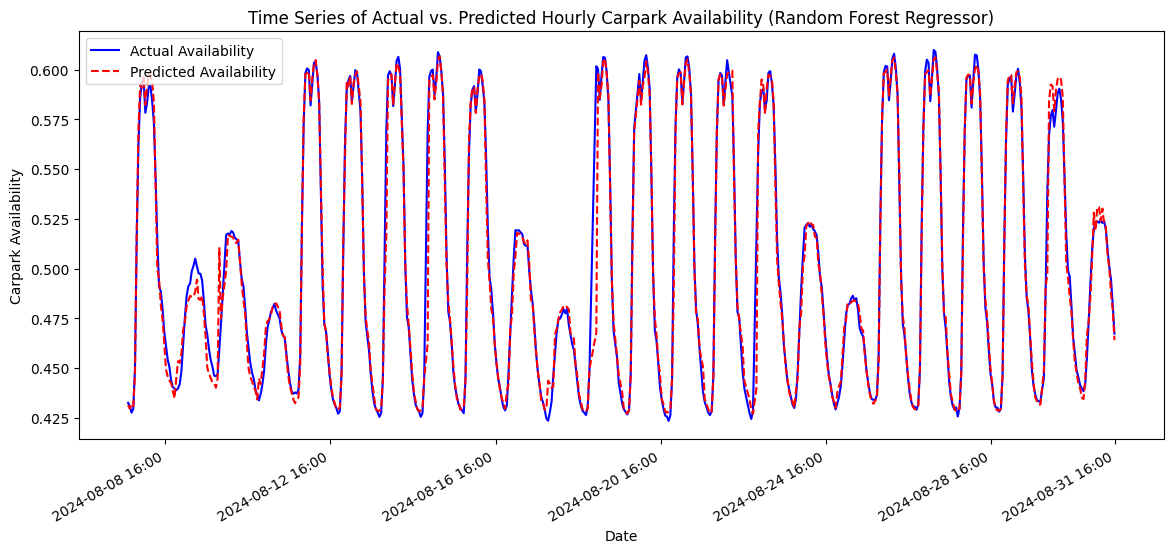

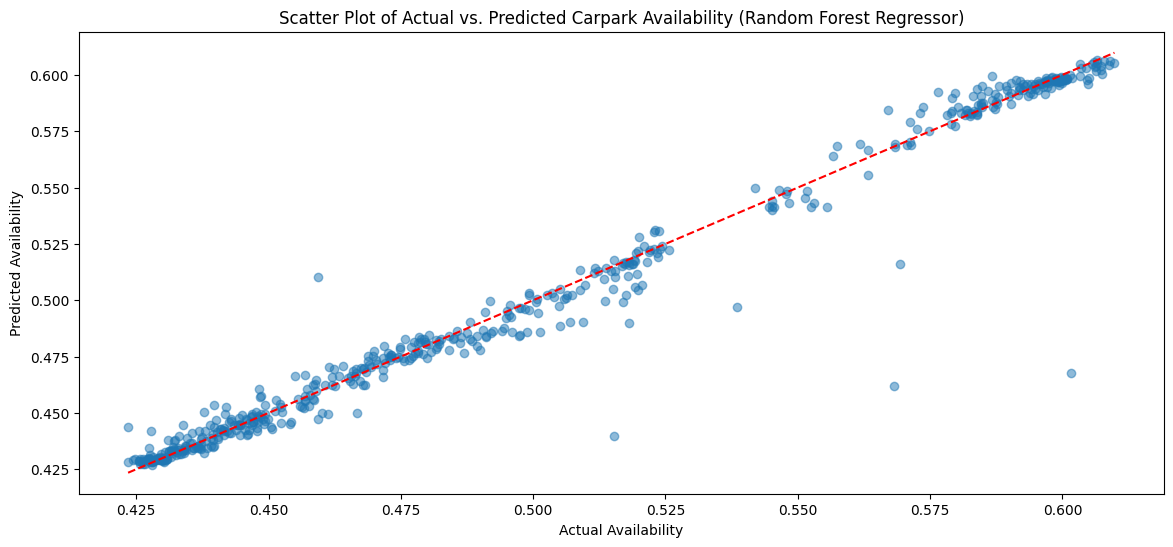

In [6]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Load data for July and August 2024
july_data = pd.read_csv(r"C:\Users\power\Downloads\carpark_availability_july_2024.csv")
august_data = pd.read_csv(r"C:\Users\power\Downloads\carpark_availability_aug_2024.csv")

# Data Preparation
july_data['timestamp'] = pd.to_datetime(july_data['timestamp'])
august_data['timestamp'] = pd.to_datetime(august_data['timestamp'])
july_data.set_index('timestamp', inplace=True)
august_data.set_index('timestamp', inplace=True)

# Feature Engineering - Creating Lag Features and Day/Hour Features
lags = [168, 4, 1] #
for lag in lags:
    july_data[f'lag_{lag}'] = july_data['average_availability'].shift(lag)
    august_data[f'lag_{lag}'] = august_data['average_availability'].shift(lag)

# Generate day and hour features for both datasets
july_data['day'] = july_data.index.day
july_data['hour'] = july_data.index.hour
august_data['day'] = august_data.index.day
august_data['hour'] = august_data.index.hour

# Drop rows with NaN values due to lagging
july_data.dropna(inplace=True)
august_data.dropna(inplace=True)

# Prepare features (X) and target (y) for training on July data
X_train = july_data[[f'lag_{lag}' for lag in lags] + ['day', 'hour']]
y_train = july_data['average_availability']

# Prepare features (X) and target (y) for testing on August data
X_test = august_data[[f'lag_{lag}' for lag in lags] + ['day', 'hour']]
y_test = august_data['average_availability']

# Scaling the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Define parameter grid for RandomizedSearchCV with 20 iterations
param_grid = {
    'n_estimators': [50, 100, 200, 300],   # Number of trees
    'max_depth': [None, 10, 20, 30],       # Depth of trees
    'min_samples_split': [2, 5, 10],       # Minimum samples to split
    'min_samples_leaf': [1, 2, 4]          # Minimum samples at each leaf
}

# Initialize model and randomized search with 20 iterations
rf_model = RandomForestRegressor(random_state=42)
tscv = TimeSeriesSplit(n_splits=5) #split to 5 time-series cross-val fold 0.5% 
random_search = RandomizedSearchCV(
    estimator=rf_model, 
    param_distributions=param_grid, 
    n_iter=20,  #set the model to run 20 iterions of different combinations of parameters 
    cv=tscv,  
    scoring='neg_mean_squared_error', 
    verbose=1, 
    n_jobs=-1, 
    random_state=42
)

# Fit the model with RandomizedSearchCV
random_search.fit(X_train_scaled, y_train_scaled)

# Best parameters and best score
best_params = random_search.best_params_
best_rf_model = random_search.best_estimator_

# Prediction and inverse scaling
y_pred_scaled = best_rf_model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()  # Reshape before inverse scaling

# Model evaluation metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # MAPE as a percentage

# Display best parameters and evaluation metrics
print("Best Parameters:", best_params)
print("Root Mean Square Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R^2):", r2)
print("Mean Absolute Percentage Error (MAPE):", mape)

# Plotting Results
# Time series plot of actual vs. predicted values
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label="Actual Availability", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted Availability", color="red", linestyle="--")
plt.title("Time Series of Actual vs. Predicted Hourly Carpark Availability (Random Forest Regressor)")
plt.xlabel("Date")
plt.ylabel("Carpark Availability")
plt.legend()
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m-%d %H:%M"))
plt.gcf().autofmt_xdate()
plt.show()

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(14, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.title("Scatter Plot of Actual vs. Predicted Carpark Availability (Random Forest Regressor)")
plt.xlabel("Actual Availability")
plt.ylabel("Predicted Availability")
plt.show()



### 2.5 (Final Recommdations on the best model based on the performance metrics)



 2.5 Make a final recommendation for the best regression model out of the 3 methods above# out of all the options we found that Ridge Regressions and Random Forest are the best models so fars based on the metrics of Root Mean Square Error and Mean Absolute Errors that we have chosen for regression models. However if given more iterations and datasets for training and testing and epoch MLP will be the better options as it will provide a more accurate performance metrics as compared to Ridge Regression and Random Forest, because MLP has the lowest RMSE as compared to all the other regression models when tested with more dataset. In summary, the best final recommended model will be the random forest as it provides the lowest RMSE and MAE values, and It balances interpretability (through feature importance) with scalability, making it suitable for future infrastructure expansions.


